In [1]:
renv::init('/oak/stanford/groups/agitler/Shared/Shared_Jupyter_Notebook_Analysis/4.1.1-OG/')

In [2]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(ggrepel)
library(pheatmap)
#library(ComplexHeatmap)
library(gplots)
library(biomaRt)

# PLEASE NOTE that fribidi must be loaded in the initialization jupyter script for ggrastr to load properly
library(ggrastr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [3]:
library(future)
plan("multiprocess", workers = availableCores())
options(future.globals.maxSize = +Inf)

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


## Save Directories for Figs and Tables

In [3]:
fig_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/Figure_Panels'
csv_dir <- '/oak/stanford/groups/agitler/Shared/Matters_Arising/CSV_Files'

## Custom Functions

In [90]:
make_volcano_plot <- function(data, labeled_pts, labeled_genes=c(), p_val_cutoff=0.01) {
    data <- data %>% 
    mutate(
        Expression = case_when(avg_log2FC >= 1 & p_val_adj <= p_val_cutoff ~ "Up-regulated",
                           avg_log2FC <= -1 & p_val_adj <= p_val_cutoff ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )
    
    data <- data %>% filter(gene!='hSOD1')


    top <- labeled_pts
   
    top_genes <- bind_rows(
      data %>% 
        filter(Expression == 'Up-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(Expression == 'Down-regulated') %>% 
        arrange(p_val_adj, desc(abs(avg_log2FC))) %>% 
        head(top),
      data %>% 
        filter(gene %in% labeled_genes)
    )
    
    
#     top_genes$Genes <- rownames(top_genes)
    
    x_scale <- max(abs(data$avg_log2FC))
    
    p1 <- ggplot(data, aes(avg_log2FC, -log(p_val_adj,10))) + # -log10 conversion 
        labs(title = "Yadav") +
        geom_point(aes(color = Expression), size = 4/5) +
        geom_label_repel(data = top_genes, mapping = aes(avg_log2FC, -log(p_val_adj,10), label = gene),
                        size = 4, max.overlaps=18)+
        xlim(-x_scale,x_scale)+
        xlab(expression("log"[2]*"FC")) + 
        ylab(expression("-log"[10]*"(p adj)")) + 
        scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) + 
        guides(colour = guide_legend(override.aes = list(size=1.5)))  + 
        #scale_y_continuous(limits = c(0,10)) +
        theme_classic() +
        theme(axis.text = element_text(size = 15), axis.title = element_text(size = 15), plot.title = element_text(size = 18, face = "bold", hjust = 0.5))       
p1  
}

## Heatmap

### Get Blum (mouse) motor neuron marker genes

In [8]:
blum <- readRDS('/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/blum.rds')

In [9]:
Idents(blum) <- blum$skeletal_motor_neuron

In [10]:
blum_skeletal_markers <- FindMarkers(blum, ident.1 ="Skeletal Motor Neurons", logfc.threshold = 0.25, max.cells.per.ident = 500, only.pos = TRUE)

In [29]:
blum_skeletal_markers

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Anxa4,2.378557e-144,1.6337663,0.940,0.118,7.387084e-140
Tns1,6.456508e-144,1.7750779,0.961,0.116,2.005198e-139
Prune2,1.045500e-142,2.1951590,0.997,0.640,3.247011e-138
Gfra1,1.618876e-124,1.5415551,0.975,0.323,5.027742e-120
Bcl6,3.533544e-117,1.0594952,0.847,0.079,1.097413e-112
Caln1,1.601482e-113,1.7543188,0.983,0.457,4.973723e-109
Nos1ap,2.630034e-103,1.6306948,0.915,0.371,8.168095e-99
Gm39185,4.641622e-102,1.0638534,0.722,0.059,1.441549e-97
Htra1,1.072414e-100,0.8845412,0.849,0.128,3.330597e-96


### Blum (mouse) motor neuron average gene expression

In [11]:
blum_skeletal_mns <- readRDS('/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/blum_mns.rds')

In [16]:
blum_skeletal_avg_exp <- AverageExpression(blum_skeletal_mns, assays = c('RNA'), group.by = "skeletal_motor_neuron") %>% as.data.frame()
colnames(blum_skeletal_avg_exp) <- c("Skeletal MNs - Mouse (Blum)")
blum_skeletal_avg_exp

The following grouping variables have 1 value and will be ignored: skeletal_motor_neuron

All grouping variables have 1 value only. Computing across all cells.



,Skeletal MNs - Mouse (Blum)
,<dbl>
Xkr4,8.762582e+00
Gm1992,9.472913e-01
Gm37381,7.339465e-03
Rp1,2.223314e-02
Sox17,3.905552e-05
Gm37323,1.680781e-04
Mrpl15,1.741522e-01
Lypla1,1.664271e-03
Gm37988,4.095192e-02


In [15]:
blum_subtype_avg_exp <- AverageExpression(blum_skeletal_mns, assays = c('RNA'), group.by = "skeletal_subtype") %>% as.data.frame()
colnames(blum_subtype_avg_exp) <- c("Alpha MNs - Mouse (Blum)", "Gamma MNs - Mouse (Blum)", "Gamma* MNs - Mouse (Blum)")
blum_subtype_avg_exp

,Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum)
,<dbl>,<dbl>,<dbl>
Xkr4,1.016373e+01,7.2802646812,6.661490026
Gm1992,1.142481e+00,0.7123064303,0.696457401
Gm37381,9.176808e-03,0.0055525732,0.004353724
Rp1,2.531424e-02,0.0168063875,0.020797658
Sox17,0.000000e+00,0.0001468027,0.000000000
Gm37323,1.961779e-04,0.0002240508,0.000000000
Mrpl15,1.518723e-01,0.2052424025,0.196511718
Lypla1,2.085752e-03,0.0003645937,0.002286916
Gm37988,3.858443e-02,0.0466694516,0.039780569


### Gautier motor neuron average gene expression

In [86]:
gautier_mns <- readRDS('/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/gautier_mns.rds')

In [88]:
gautier_skeletal_avg_exp <- AverageExpression(gautier_mns, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(gautier_skeletal_avg_exp) <- c("Skeletal MNs - Human (Gautier)")
# gautier_skeletal_avg_exp

The following grouping variables have 1 value and will be ignored: motor_neuron

All grouping variables have 1 value only. Computing across all cells.



In [89]:
gautier_subtype_avg_exp <- AverageExpression(gautier_mns, assays = c('RNA'), group.by = "motor_neuron_subtype") %>% as.data.frame()
colnames(gautier_subtype_avg_exp) <- c("Alpha MNs - Human (Gautier)", "Gamma MNs - Human (Gautier)")
# gautier_subtype_avg_exp

### Yadav motor neuron average gene expression

In [91]:
yadav_mns <- readRDS('/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/yadav_mns.rds')

In [92]:
yadav_mn_avg_exp <- AverageExpression(yadav_mns, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(yadav_mn_avg_exp) <- c("Motoneurons - Human (Yadav)")
# yadav_mn_avg_exp

The following grouping variables have 1 value and will be ignored: motor_neuron

All grouping variables have 1 value only. Computing across all cells.



### Function to convert mouse to human gene names

In [93]:
# Function to convert mouse to human gene names
convertMouseGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl", host = "https://dec2021.archive.ensembl.org/")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl", host = "https://dec2021.archive.ensembl.org/")

humanx = getLDS(attributes = c("mgi_symbol"), filters = "mgi_symbol", values = x , mart = mouse, attributesL = c("hgnc_symbol"), martL = human, uniqueRows=T)

return(humanx)
}

### Get mouse skeletal motor neuron markers that map to human genes

In [94]:
mouse_skeletal_markers <- rownames(blum_skeletal_markers)

ERROR: Error in rownames(blum_skeletal_markers): object 'blum_skeletal_markers' not found


In [84]:
mouse_markers_to_human <- convertMouseGeneList(mouse_skeletal_markers) %>% dplyr::select(HGNC.symbol)

In [85]:
mouse_markers_to_human

HGNC.symbol
<chr>
TBC1D4
ACSS2
NDRG3
PDE9A
DLGAP1
SEL1L3
TTC39B
MINDY3
RGS6


### Combine motor neuron average expression from Blum, Gautier, Yadav

In [30]:
mouse_genes <- rownames(blum_skeletal_avg_exp)

In [32]:
mouse_genes_to_human <- convertMouseGeneList(mouse_genes)

In [86]:
mouse_genes_to_human

MGI.symbol,HGNC.symbol
<chr>,<chr>
mt-Nd4,MT-ND4
mt-Atp8,MT-ATP8
mt-Atp6,MT-ATP6
mt-Nd6,MT-ND6
mt-Co1,MT-CO1
mt-Nd3,MT-ND3
mt-Nd1,MT-ND1
mt-Nd5,MT-ND5
mt-Co3,MT-CO3


In [94]:
unique_mouse <- mouse_genes_to_human %>% group_by(MGI.symbol) %>% filter(n() == 1)
unique_mouse

MGI.symbol,HGNC.symbol
<chr>,<chr>
mt-Nd4,MT-ND4
mt-Atp8,MT-ATP8
mt-Atp6,MT-ATP6
mt-Nd6,MT-ND6
mt-Co1,MT-CO1
mt-Nd3,MT-ND3
mt-Nd1,MT-ND1
mt-Nd5,MT-ND5
mt-Co3,MT-CO3


In [95]:
unique_human <- mouse_genes_to_human %>% group_by(HGNC.symbol) %>% filter(n() == 1)
unique_human

MGI.symbol,HGNC.symbol
<chr>,<chr>
mt-Nd4,MT-ND4
mt-Atp8,MT-ATP8
mt-Atp6,MT-ATP6
mt-Nd6,MT-ND6
mt-Co1,MT-CO1
mt-Nd3,MT-ND3
mt-Nd1,MT-ND1
mt-Nd5,MT-ND5
mt-Co3,MT-CO3


In [96]:
mouse_genes_to_human_dedup <- inner_join(unique_mouse, unique_human)
mouse_genes_to_human_dedup

Joining, by = c("MGI.symbol", "HGNC.symbol")



MGI.symbol,HGNC.symbol
<chr>,<chr>
mt-Nd4,MT-ND4
mt-Atp8,MT-ATP8
mt-Atp6,MT-ATP6
mt-Nd6,MT-ND6
mt-Co1,MT-CO1
mt-Nd3,MT-ND3
mt-Nd1,MT-ND1
mt-Nd5,MT-ND5
mt-Co3,MT-CO3


In [97]:
blum_skeletal_avg_exp$MGI.symbol <- rownames(blum_skeletal_avg_exp)
blum_skeletal_avg_exp

,Skeletal MNs - Mouse (Blum),MGI.symbol
,<dbl>,<chr>
Xkr4,8.762582e+00,Xkr4
Gm1992,9.472913e-01,Gm1992
Gm37381,7.339465e-03,Gm37381
Rp1,2.223314e-02,Rp1
Sox17,3.905552e-05,Sox17
Gm37323,1.680781e-04,Gm37323
Mrpl15,1.741522e-01,Mrpl15
Lypla1,1.664271e-03,Lypla1
Gm37988,4.095192e-02,Gm37988


In [98]:
mn_avg_exp_combined <- inner_join(blum_skeletal_avg_exp, mouse_genes_to_human_dedup, by = "MGI.symbol")
mn_avg_exp_combined

Skeletal MNs - Mouse (Blum),MGI.symbol,HGNC.symbol
<dbl>,<chr>,<chr>
8.762582e+00,Xkr4,XKR4
2.223314e-02,Rp1,RP1
3.905552e-05,Sox17,SOX17
1.741522e-01,Mrpl15,MRPL15
1.664271e-03,Lypla1,LYPLA1
3.003327e-01,Tcea1,TCEA1
5.233965e-01,Rgs20,RGS20
1.476771e+00,Atp6v1h,ATP6V1H
4.819192e-03,Oprk1,OPRK1


In [99]:
blum_subtype_avg_exp$MGI.symbol <- rownames(blum_subtype_avg_exp)
mn_avg_exp_combined <- inner_join(blum_subtype_avg_exp, mn_avg_exp_combined, by = "MGI.symbol")
mn_avg_exp_combined

Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),MGI.symbol,Skeletal MNs - Mouse (Blum),HGNC.symbol
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1.016373e+01,7.280265e+00,6.661490026,Xkr4,8.762582e+00,XKR4
2.531424e-02,1.680639e-02,0.020797658,Rp1,2.223314e-02,RP1
0.000000e+00,1.468027e-04,0.000000000,Sox17,3.905552e-05,SOX17
1.518723e-01,2.052424e-01,0.196511718,Mrpl15,1.741522e-01,MRPL15
2.085752e-03,3.645937e-04,0.002286916,Lypla1,1.664271e-03,LYPLA1
2.903103e-01,3.114560e-01,0.314597283,Tcea1,3.003327e-01,TCEA1
4.640495e-01,5.975009e-01,0.595755991,Rgs20,5.233965e-01,RGS20
1.642208e+00,1.285539e+00,1.252511399,Atp6v1h,1.476771e+00,ATP6V1H
6.698877e-03,2.336902e-03,0.002726051,Oprk1,4.819192e-03,OPRK1


In [100]:
gautier_skeletal_avg_exp$HGNC.symbol <- rownames(gautier_skeletal_avg_exp)
mn_avg_exp_combined <- right_join(gautier_skeletal_avg_exp, mn_avg_exp_combined, by = "HGNC.symbol")
mn_avg_exp_combined

Skeletal MNs - Human (Gautier),HGNC.symbol,Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),MGI.symbol,Skeletal MNs - Mouse (Blum)
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.019769845,SAMD11,0.014810293,0.023209007,0.021080946,Samd11,0.018179903
0.166515394,NOC2L,0.379024840,0.278086870,0.271587325,Noc2l,0.332721245
0.000000000,PLEKHN1,0.282069601,0.269120697,0.305674257,Plekhn1,0.282897938
0.000000000,PERM1,0.004472948,0.005419854,0.005202645,Perm1,0.004856965
0.042451004,ISG15,0.004822046,0.005067599,0.003317436,Isg15,0.004614986
0.228550359,AGRN,1.377317014,0.631798009,0.415535198,Agrn,1.004862136
0.000000000,RNF223,0.008147184,0.006432895,0.004640974,Rnf223,0.007056365
0.201171222,C1orf159,0.145270048,0.136937444,0.132797594,9430015G10Rik,0.140795282
0.000000000,TTLL10,0.007488783,0.004946551,0.012188936,Ttll10,0.007663339


In [101]:
gautier_subtype_avg_exp$HGNC.symbol <- rownames(gautier_subtype_avg_exp)
mn_avg_exp_combined <- right_join(gautier_subtype_avg_exp, mn_avg_exp_combined, by = "HGNC.symbol")
mn_avg_exp_combined

Alpha MNs - Human (Gautier),Gamma MNs - Human (Gautier),HGNC.symbol,Skeletal MNs - Human (Gautier),Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),MGI.symbol,Skeletal MNs - Mouse (Blum)
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.079079381,0.000000000,SAMD11,0.019769845,0.014810293,0.023209007,0.021080946,Samd11,0.018179903
0.150103371,0.171986068,NOC2L,0.166515394,0.379024840,0.278086870,0.271587325,Noc2l,0.332721245
0.000000000,0.000000000,PLEKHN1,0.000000000,0.282069601,0.269120697,0.305674257,Plekhn1,0.282897938
0.000000000,0.000000000,PERM1,0.000000000,0.004472948,0.005419854,0.005202645,Perm1,0.004856965
0.053122401,0.038893872,ISG15,0.042451004,0.004822046,0.005067599,0.003317436,Isg15,0.004614986
0.200629810,0.237857208,AGRN,0.228550359,1.377317014,0.631798009,0.415535198,Agrn,1.004862136
0.000000000,0.000000000,RNF223,0.000000000,0.008147184,0.006432895,0.004640974,Rnf223,0.007056365
0.100934727,0.234583387,C1orf159,0.201171222,0.145270048,0.136937444,0.132797594,9430015G10Rik,0.140795282
0.000000000,0.000000000,TTLL10,0.000000000,0.007488783,0.004946551,0.012188936,Ttll10,0.007663339


In [102]:
yadav_mn_avg_exp$HGNC.symbol <- rownames(yadav_mn_avg_exp)
mn_avg_exp_combined <- right_join(yadav_mn_avg_exp, mn_avg_exp_combined, by = "HGNC.symbol")
mn_avg_exp_combined

Motoneurons - Human (Yadav),HGNC.symbol,Alpha MNs - Human (Gautier),Gamma MNs - Human (Gautier),Skeletal MNs - Human (Gautier),Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),MGI.symbol,Skeletal MNs - Mouse (Blum)
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.125179022,SAMD11,0.079079381,0.000000000,0.019769845,0.014810293,0.023209007,0.021080946,Samd11,0.018179903
0.437643108,NOC2L,0.150103371,0.171986068,0.166515394,0.379024840,0.278086870,0.271587325,Noc2l,0.332721245
0.002824492,PLEKHN1,0.000000000,0.000000000,0.000000000,0.282069601,0.269120697,0.305674257,Plekhn1,0.282897938
0.000000000,PERM1,0.000000000,0.000000000,0.000000000,0.004472948,0.005419854,0.005202645,Perm1,0.004856965
0.355440274,ISG15,0.053122401,0.038893872,0.042451004,0.004822046,0.005067599,0.003317436,Isg15,0.004614986
0.579469181,AGRN,0.200629810,0.237857208,0.228550359,1.377317014,0.631798009,0.415535198,Agrn,1.004862136
0.000000000,RNF223,0.000000000,0.000000000,0.000000000,0.008147184,0.006432895,0.004640974,Rnf223,0.007056365
0.167074206,C1orf159,0.100934727,0.234583387,0.201171222,0.145270048,0.136937444,0.132797594,9430015G10Rik,0.140795282
0.007034350,TTLL10,0.000000000,0.000000000,0.000000000,0.007488783,0.004946551,0.012188936,Ttll10,0.007663339


In [103]:
# Set NA to 0
mn_avg_exp_combined[is.na(mn_avg_exp_combined)] = 0

In [104]:
mn_avg_exp_combined <- dplyr::select(mn_avg_exp_combined, -MGI.symbol)

In [105]:
mn_marker_avg_exp_combined <- inner_join(mn_avg_exp_combined, mouse_markers_to_human, by = "HGNC.symbol")
mn_marker_avg_exp_combined

Motoneurons - Human (Yadav),HGNC.symbol,Alpha MNs - Human (Gautier),Gamma MNs - Human (Gautier),Skeletal MNs - Human (Gautier),Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),Skeletal MNs - Mouse (Blum)
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.752652e-01,PRKCZ,0.73705998,0.63648405,0.66162803,1.8676760,1.4297906,2.3000181,1.8294497
4.762082e+00,CAMTA1,5.97934552,7.58042927,7.18015833,10.6595050,10.9879775,12.6631712,11.1096262
6.970947e+00,UTS2,3.09669145,0.05209262,0.81324233,0.2145645,0.1014637,0.6418500,0.2618288
5.081056e-02,FAM131C,0.03819859,0.12328640,0.10201445,0.2547909,0.3126158,0.3962390,0.2957818
1.448470e-01,IGSF21,0.21049695,0.47855520,0.41154064,1.1095228,1.0675138,1.9544222,1.2513032
9.330081e-03,CDA,0.00000000,0.02782476,0.02086857,0.4360788,0.9873101,0.6786361,0.6266402
2.461488e-01,RAP1GAP,0.06067918,0.28308445,0.22748313,1.3846642,1.8374042,1.7613632,1.5733073
4.779691e-01,ASAP3,0.42375609,0.24629723,0.29066195,0.9317207,0.4609353,0.2880709,0.6899493
1.288691e+00,EPB41,4.31400158,4.21518125,4.23988634,5.6969246,3.4000972,4.3017325,4.8332958


In [106]:
row.names(mn_marker_avg_exp_combined) <- mn_marker_avg_exp_combined$HGNC.symbol
mn_marker_avg_exp_combined <- dplyr::select(mn_marker_avg_exp_combined, -HGNC.symbol)
mn_marker_avg_exp_combined

,Motoneurons - Human (Yadav),Alpha MNs - Human (Gautier),Gamma MNs - Human (Gautier),Skeletal MNs - Human (Gautier),Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),Skeletal MNs - Mouse (Blum)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PRKCZ,8.752652e-01,0.73705998,0.63648405,0.66162803,1.8676760,1.4297906,2.3000181,1.8294497
CAMTA1,4.762082e+00,5.97934552,7.58042927,7.18015833,10.6595050,10.9879775,12.6631712,11.1096262
UTS2,6.970947e+00,3.09669145,0.05209262,0.81324233,0.2145645,0.1014637,0.6418500,0.2618288
FAM131C,5.081056e-02,0.03819859,0.12328640,0.10201445,0.2547909,0.3126158,0.3962390,0.2957818
IGSF21,1.448470e-01,0.21049695,0.47855520,0.41154064,1.1095228,1.0675138,1.9544222,1.2513032
CDA,9.330081e-03,0.00000000,0.02782476,0.02086857,0.4360788,0.9873101,0.6786361,0.6266402
RAP1GAP,2.461488e-01,0.06067918,0.28308445,0.22748313,1.3846642,1.8374042,1.7613632,1.5733073
ASAP3,4.779691e-01,0.42375609,0.24629723,0.29066195,0.9317207,0.4609353,0.2880709,0.6899493
EPB41,1.288691e+00,4.31400158,4.21518125,4.23988634,5.6969246,3.4000972,4.3017325,4.8332958


In [107]:
mn_marker_avg_exp_combined %>% filter(rownames(mn_marker_avg_exp_combined) == "NEFL")

,Motoneurons - Human (Yadav),Alpha MNs - Human (Gautier),Gamma MNs - Human (Gautier),Skeletal MNs - Human (Gautier),Alpha MNs - Mouse (Blum),Gamma MNs - Mouse (Blum),Gamma* MNs - Mouse (Blum),Skeletal MNs - Mouse (Blum)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NEFL,194.4816,4.661291,3.613903,3.87575,1.544944,1.569082,1.278636,1.503155


In [4]:
mn_marker_avg_exp_combined <- readRDS('/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/mn_marker_avg_exp_combined.rds')

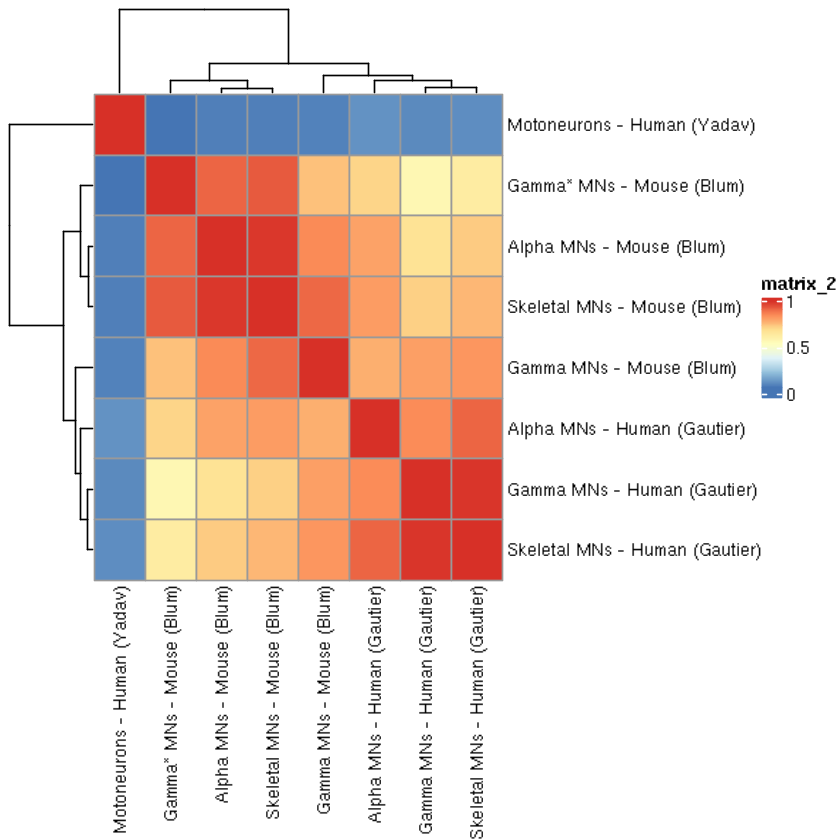

In [13]:
pheatmap(cor(as.matrix(mn_marker_avg_exp_combined)))

In [14]:
svglite(filename = paste(fig_dir, 'heatmap.svg', sep='/'))
pheatmap(cor(as.matrix(mn_marker_avg_exp_combined))
dev.off()

ERROR: Error in parse(text = x, srcfile = src): <text>:3:1: unexpected symbol
2: pheatmap(cor(as.matrix(mn_marker_avg_exp_combined))
3: dev.off
   ^


In [14]:
pheatmap(cor(as.matrix(mn_marker_avg_exp_combined)), filename = paste(fig_dir, 'heatmap2.pdf', sep='/'), cellwidth = 20, cellheight = 20, fontsize = 14, legend_breaks = 0:1)

In [118]:
pheatmap(cor(as.matrix(mn_marker_avg_exp_combined)), filename = paste(fig_dir, 'heatmap.pdf', sep='/'), width = 26, height = 11, fontsize = 24, angle_col = c("45"))

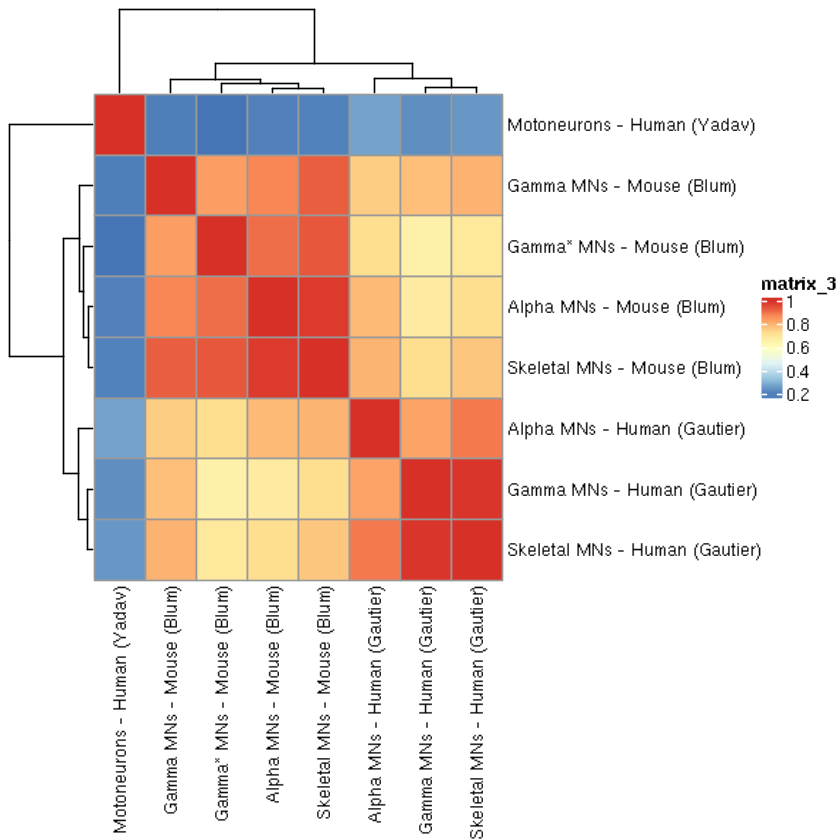

In [110]:
x <- mn_avg_exp_combined
row.names(x) <- x$HGNC.symbol
x <- dplyr::select(x, -HGNC.symbol)
pheatmap(cor(as.matrix(x)))

### Save objects

In [252]:
saveRDS(mn_marker_avg_exp_combined, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/mn_marker_avg_exp_combined.rds')
saveRDS(mn_avg_exp_combined, file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/mn_avg_exp_combined.rds')

## lncRNA analysis

In [32]:
ensembl <- useMart(biomart = "ENSEMBL_MART_ENSEMBL",dataset="hsapiens_gene_ensembl")
lncrna <- getBM(attributes= c('hgnc_symbol'),
                 filters = "biotype",
                 value = 'lncRNA',
                 mart = ensembl)

### Yadav

In [35]:
yadav_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')

In [36]:
Idents(yadav_neurons) <- yadav_neurons$motor_neuron

In [37]:
# min.pct=0.1 to select genes that are expressed in at least 10% of yadav motor neurons or other neurons
yadav_motoneuron_markers <- FindMarkers(yadav_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0.1, max.cells.per.ident = 40)

In [38]:
yadav_motoneuron_markers$hgnc_symbol <- rownames(yadav_motoneuron_markers)

In [39]:
yadav_motoneuron_lncrna_markers <- inner_join(yadav_motoneuron_markers, lncrna, by = "hgnc_symbol")

In [40]:
yadav_motoneuron_lncrna_markers <- yadav_motoneuron_lncrna_markers 

In [41]:
yadav_motoneuron_lncrna_markers$gene <- yadav_motoneuron_lncrna_markers$hgnc_symbol

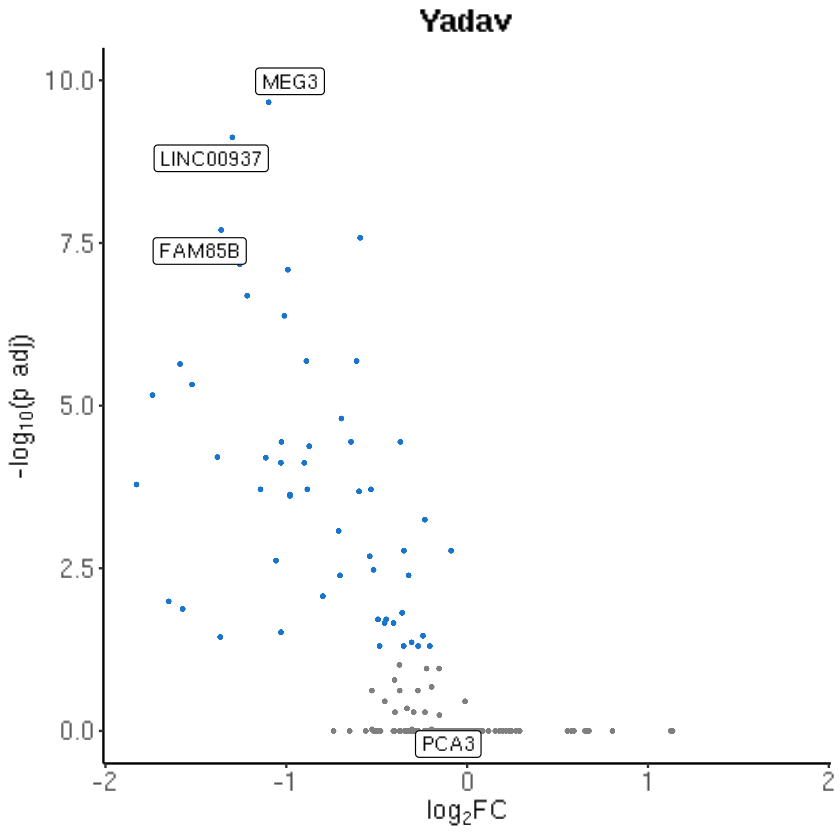

In [67]:
yadav_motoneuron_lncrna_volcano_plot <- make_volcano_plot(as_tibble(yadav_motoneuron_lncrna_markers), 3, p_val_cutoff = 0.05, labeled_genes=c('PCA3'))
yadav_motoneuron_lncrna_volcano_plot <- rasterize(yadav_motoneuron_lncrna_volcano_plot, layers="Point", dpi=500) + NoLegend()
yadav_motoneuron_lncrna_volcano_plot

In [68]:
ggsave(yadav_motoneuron_lncrna_volcano_plot, filename = paste(fig_dir, 'yadav_motoneuron_lncrna_volcano_plot.svg', sep='/'),device='svg', width = 3.4, height = 4.698, units = "in")

### Gautier

In [6]:
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')

In [45]:
Idents(gautier_neurons) <- gautier_neurons$motor_neuron

In [46]:
# min.pct=0.1 to select genes that are expressed in at least 10% of motor neurons or other neurons
gautier_mn_markers <- FindMarkers(gautier_neurons, ident.1 = "Motor Neurons", ident.2 = "Other Neurons", logfc.threshold=0, min.pct=0.1, max.cells.per.ident = 40)

In [47]:
gautier_mn_markers$hgnc_symbol <- rownames(gautier_mn_markers)

In [48]:
gautier_mn_lncrna_markers <- inner_join(gautier_mn_markers, lncrna, by = "hgnc_symbol")

In [49]:
gautier_mn_lncrna_markers <- gautier_mn_lncrna_markers 

In [50]:
gautier_mn_lncrna_markers$gene <- gautier_mn_lncrna_markers$hgnc_symbol

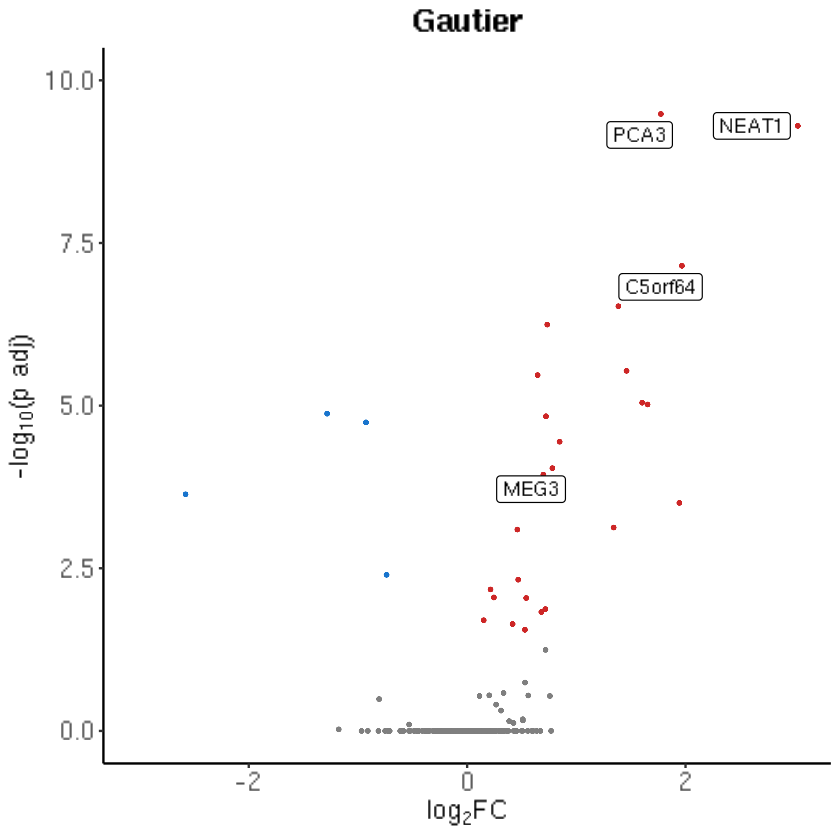

In [64]:
gautier_mn_lncrna_volcano_plot <- make_volcano_plot(as_tibble(gautier_mn_lncrna_markers), 0, p_val_cutoff = 0.05, labeled_genes=c('PCA3', 'NEAT1', 'C5orf64', 'MEG3'))
gautier_mn_lncrna_volcano_plot <- rasterize(gautier_mn_lncrna_volcano_plot, layers="Point", dpi=500) + NoLegend()
gautier_mn_lncrna_volcano_plot

In [65]:
ggsave(gautier_mn_lncrna_volcano_plot, filename = paste(fig_dir, 'gautier_mn_lncrna_volcano_plot.svg', sep='/'), device='svg', width = 3.4, height = 4.698, units = "in")

## Intronic read analysis

### Yadav

### Get barcodes by orig.ident

In [84]:
yadav <- readRDS(file = '/oak/stanford/groups/agitler/Olivia/Single_cell/Gautier_Yadav/yadav.rds')

In [90]:
yadav_barcodes <- yadav
yadav_barcodes$barcode <- rownames(yadav_barcodes@meta.data)
yadav_barcodes@meta.data <- yadav_barcodes@meta.data %>% mutate(barcode = stringr::str_remove(barcode, "_.+"))

#### Note: could not find data for Tsai1A, so those data are not included in the subsequent analysis

In [91]:
H1_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H1") %>% dplyr::select(barcode)
H1_barcodes$orig.barcode <- rownames(H1_barcodes)

In [92]:
H4_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H4") %>% dplyr::select(barcode)
H4_barcodes$orig.barcode <- rownames(H4_barcodes)

In [93]:
H5_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H5") %>% dplyr::select(barcode)
H5_barcodes$orig.barcode <- rownames(H5_barcodes)

In [94]:
H6B_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H6B") %>% dplyr::select(barcode)
H6B_barcodes$orig.barcode <- rownames(H6B_barcodes)

In [95]:
H7B_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "H7B") %>% dplyr::select(barcode)
H7B_barcodes$orig.barcode <- rownames(H7B_barcodes)

In [96]:
Tsai1B_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "Tsai1B") %>% dplyr::select(barcode)
Tsai1B_barcodes$orig.barcode <- rownames(Tsai1B_barcodes)

In [97]:
Tsai2_barcodes <- yadav_barcodes@meta.data %>% dplyr::filter(orig.ident == "Tsai2") %>% dplyr::select(barcode)
Tsai2_barcodes$orig.barcode <- rownames(Tsai2_barcodes)

### Load data analyzed with and without including intronic reads

In [98]:
H1_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H1_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H1_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H1_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [107]:
H4_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H4_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H4_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H4_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [100]:
H5_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H5_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H5_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H5_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [101]:
H6B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H6B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H6B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H6B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [102]:
H7B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H7B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
H7B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/H7B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [103]:
Tsai1B_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai1B_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
Tsai1B_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai1B_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

In [104]:
Tsai2_with_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai2_with_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()
Tsai2_without_introns <- Read10X('/oak/stanford/groups/agitler/Olivia/single_cell_data/10X_analyzed/Yadav/Tsai2_without_introns/outs/raw_feature_bc_matrix') %>% CreateSeuratObject()

### Function to get prop of intronic reads

In [108]:
get_prop_intronic <- function(with_introns, without_introns, barcodes){

    with_introns_all <- subset(with_introns, cells = barcodes$barcode)
    with_introns_all$barcode <- rownames(with_introns_all@meta.data)
    
    without_introns_all <- subset(without_introns, cells = barcodes$barcode)
    without_introns_all$barcode <- rownames(without_introns_all@meta.data)
    
    prop.intronic <- inner_join(with_introns_all@meta.data, without_introns_all@meta.data, by = "barcode")
    prop.intronic$prop_intronic <- (prop.intronic$nCount_RNA.x - prop.intronic$nCount_RNA.y)/prop.intronic$nCount_RNA.x
    prop.intronic <- inner_join(prop.intronic, barcodes, by = "barcode")
    rownames(prop.intronic) <- prop.intronic$orig.barcode
    prop.intronic <- dplyr::select(prop.intronic, prop_intronic)

return(prop.intronic)
}

In [109]:
H1_prop_intronic <- get_prop_intronic(H1_with_introns, H1_without_introns, H1_barcodes)
H4_prop_intronic <- get_prop_intronic(H4_with_introns, H4_without_introns, H4_barcodes)
H5_prop_intronic <- get_prop_intronic(H5_with_introns, H5_without_introns, H5_barcodes)
H6B_prop_intronic <- get_prop_intronic(H6B_with_introns, H6B_without_introns, H6B_barcodes)
H7B_prop_intronic <- get_prop_intronic(H7B_with_introns, H7B_without_introns, H7B_barcodes)
Tsai1B_prop_intronic <- get_prop_intronic(Tsai1B_with_introns, Tsai1B_without_introns, Tsai1B_barcodes)
Tsai2_prop_intronic <- get_prop_intronic(Tsai2_with_introns, Tsai2_without_introns, Tsai2_barcodes)

In [110]:
prop_intronic_combo <- dplyr::bind_rows(H1_prop_intronic, H4_prop_intronic) %>% dplyr::bind_rows(H5_prop_intronic) %>% dplyr::bind_rows(H6B_prop_intronic) %>% dplyr::bind_rows(H7B_prop_intronic) %>% dplyr::bind_rows(Tsai1B_prop_intronic) %>% dplyr::bind_rows(Tsai2_prop_intronic)

In [111]:
yadav_wo_Tsai1A <- subset(yadav, subset = orig.ident != "Tsai1A")

In [112]:
yadav_prop_intronic <- AddMetaData(yadav_wo_Tsai1A, prop_intronic_combo)

In [114]:
yadav_prop_intronic_neurons <- subset(yadav_prop_intronic, subset = top_level_annotation == "Neurons")

In [115]:
yadav_prop_intronic_neurons$motor_neuron <- ifelse(yadav_prop_intronic_neurons$subtype_annotation == "Motoneurons", yes = "Motor Neurons", no = "Other Neurons")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



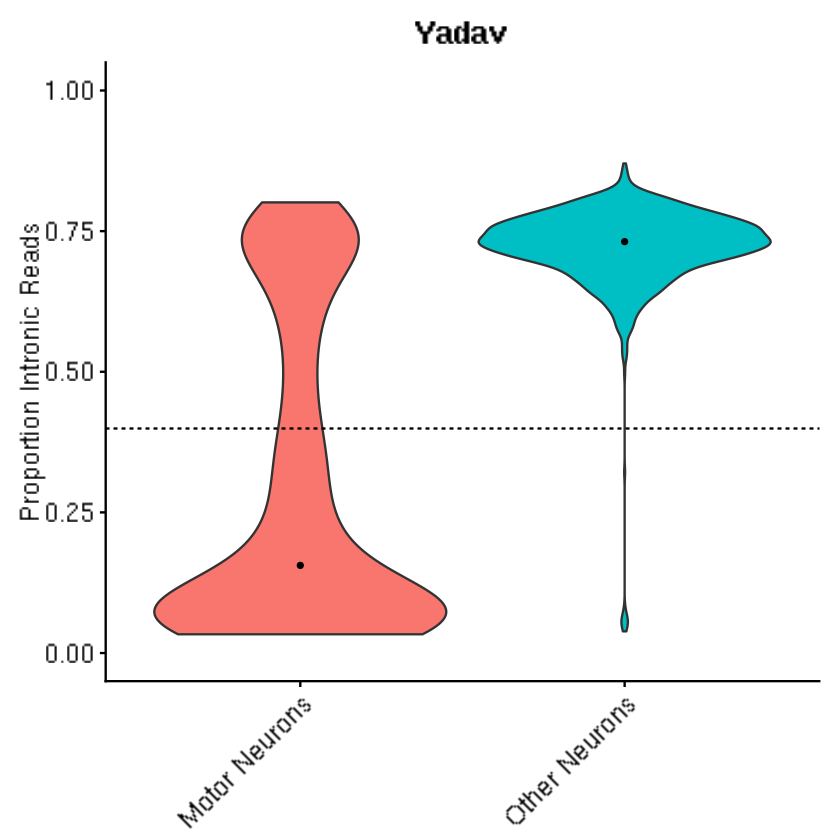

In [13]:
yadav_intronic <- VlnPlot(yadav_prop_intronic_neurons, group.by = "motor_neuron", features = "prop_intronic", pt.size = 0) + 
  labs(title = "Yadav", y = "Proportion Intronic Reads") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,1)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank()) & geom_hline(linetype = "dashed", yintercept = 0.4)

yadav_intronic

In [14]:
ggsave(yadav_intronic, filename = paste(fig_dir, 'yadav_intronic.svg', sep='/'), device='svg', width = 3.4, height = 5.5, units = "in")

In [12]:
saveRDS(yadav_prop_intronic, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic.rds')
saveRDS(yadav_prop_intronic_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic_neurons.rds')

In [4]:
yadav_prop_intronic <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic.rds')
yadav_prop_intronic_neurons <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic_neurons.rds')

In [5]:
filter(yadav_prop_intronic_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$prop_intronic)}

[1] 0.1558029

In [6]:
filter(yadav_prop_intronic_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$prop_intronic)}

[1] 0.7313532

### High intronic Yadav MNs vs. other neurons

In [76]:
yadav_high_intronic <- subset(x = yadav_prop_intronic_neurons, subset = prop_intronic >= 0.4)

In [77]:
Idents(yadav_high_intronic) <- yadav_high_intronic$motor_neuron
table(yadav_high_intronic$motor_neuron)


Motor Neurons Other Neurons 
          365          1587 

In [79]:
yadav_high_intronic_markers <-  FindMarkers(yadav_high_intronic, ident.1 = 'Motor Neurons', ident.2 = 'Other Neurons', logfc.threshold=0, min.pct=0,  max.cells.per.ident = 365)
yadav_high_intronic_markers$gene <- rownames(yadav_high_intronic_markers)
rownames(yadav_high_intronic_markers) <- NULL

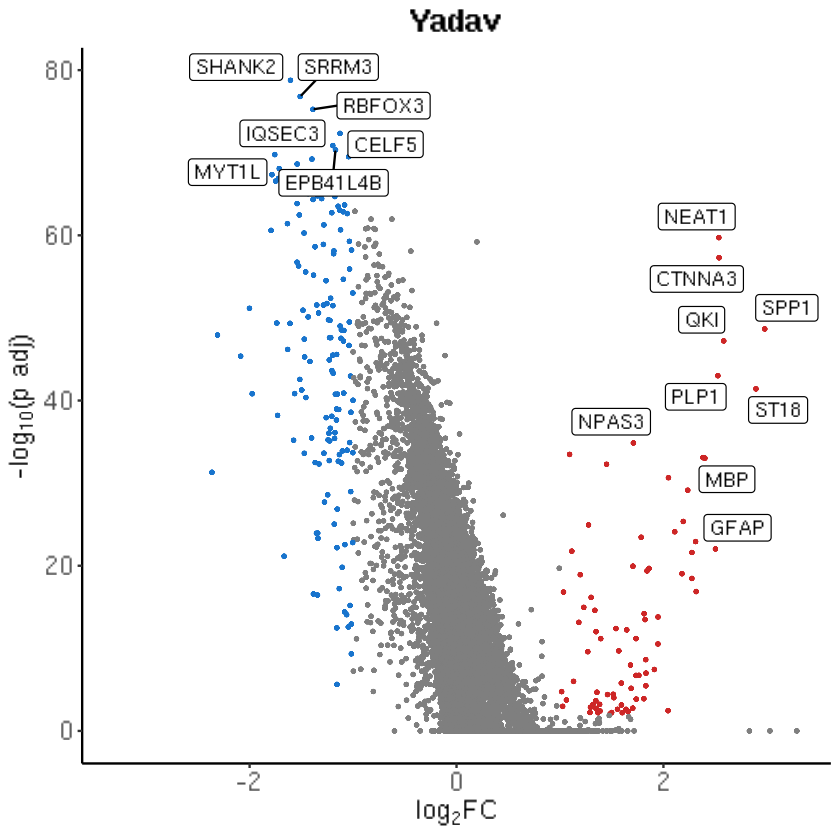

In [107]:
yadav_high_intronic_volcano_plot <- make_volcano_plot(yadav_high_intronic_markers, 7, labeled_genes=c('MBP', 'GFAP')) 
yadav_high_intronic_volcano_plot <- rasterize(yadav_high_intronic_volcano_plot, layers="Point", dpi=500) + NoLegend()
# log2FC 0.83
yadav_high_intronic_volcano_plot

In [108]:
ggsave(yadav_high_intronic_volcano_plot, filename = paste(fig_dir, 'yadav_high_intronic_volcano_plot.svg', sep='/'),device='svg', width = 6.4, height = 4.848, units = "in")

### Gautier dataset

In [15]:
gautier_prop_intronic <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic.rds')
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')

In [26]:
neurons <- colnames(gautier_neurons)
gautier_prop_intronic_neurons <- subset(gautier_prop_intronic, cells = neurons)
gautier_prop_intronic_neurons <- AddMetaData(gautier_prop_intronic_neurons, gautier_neurons@meta.data$motor_neuron, col.name = "motor_neuron")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



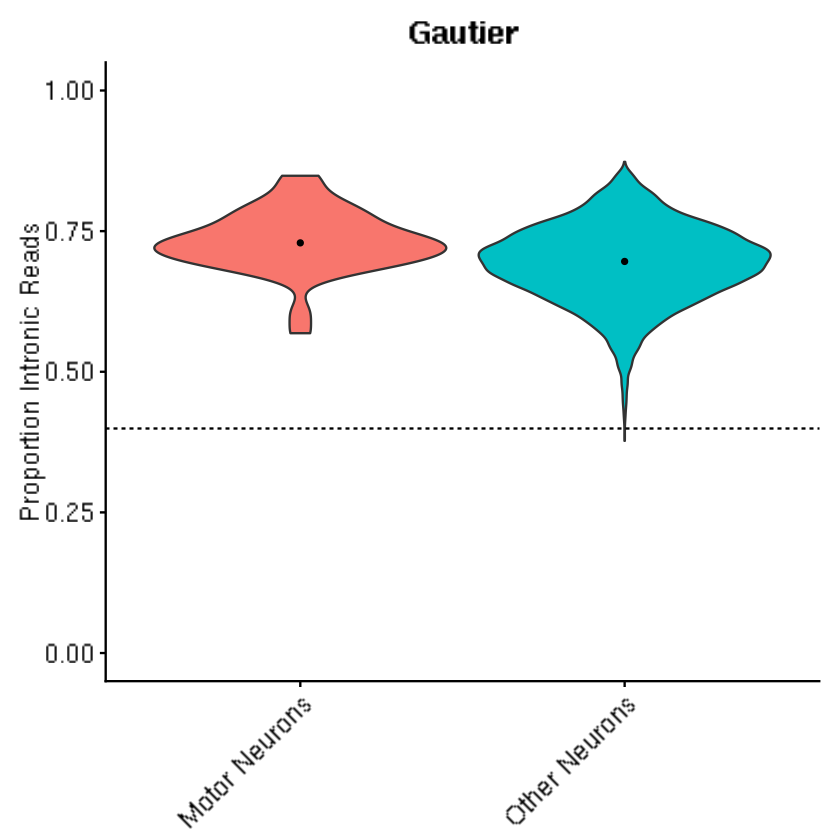

In [28]:
gautier_intronic <- VlnPlot(gautier_prop_intronic_neurons, group.by = "motor_neuron", features = "prop_intronic", pt.size = 0) + 
  labs(title = "Gautier", y = "Proportion Intronic Reads") + NoLegend() + FontSize(
  x.text = 15,
  y.text = 15,
  y.title = 15,
  main = 18,
) + scale_y_continuous(limits = c(0,1)) + stat_summary(fun = median, geom='point', size = 1) + theme(axis.title.x = element_blank()) & geom_hline(linetype = "dashed", yintercept = 0.4)

gautier_intronic

In [29]:
ggsave(gautier_intronic, filename = paste(fig_dir, 'gautier_intronic.svg', sep='/'), device='svg', width = 3.4, height = 5.5, units = "in")

In [30]:
saveRDS(gautier_prop_intronic_neurons, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic_neurons.rds')

In [7]:
gautier_prop_intronic_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic_neurons.rds')

In [8]:
filter(gautier_prop_intronic_neurons@meta.data, motor_neuron == "Motor Neurons") %>% {median(.$prop_intronic)}

[1] 0.7291398

In [9]:
filter(gautier_prop_intronic_neurons@meta.data, motor_neuron == "Other Neurons") %>% {median(.$prop_intronic)}

[1] 0.6961284

### Split motoneurons into high and low percentage intronic reads (40% cutoff)

### Yadav dataset

In [70]:
yadav_prop_intronic_mns <- subset(yadav_prop_intronic_neurons, subset = motor_neuron == "Motor Neurons")

In [71]:
yadav_prop_intronic_mns$intronic <- ifelse(yadav_prop_intronic_mns$prop_intronic >= 0.4, yes = "High", no = "Low")

In [72]:
Idents(yadav_prop_intronic_mns) <- yadav_prop_intronic_mns$intronic
# table(yadav_mns_percent_intronic$intronic)

In [73]:
yadav_intronic_markers <-  FindMarkers(yadav_prop_intronic_mns, ident.1 = "Low", ident.2='High', logfc.threshold=0, min.pct=0,  max.cells.per.ident = 365)
yadav_intronic_markers$gene <- rownames(yadav_intronic_markers)
rownames(yadav_intronic_markers) <- NULL

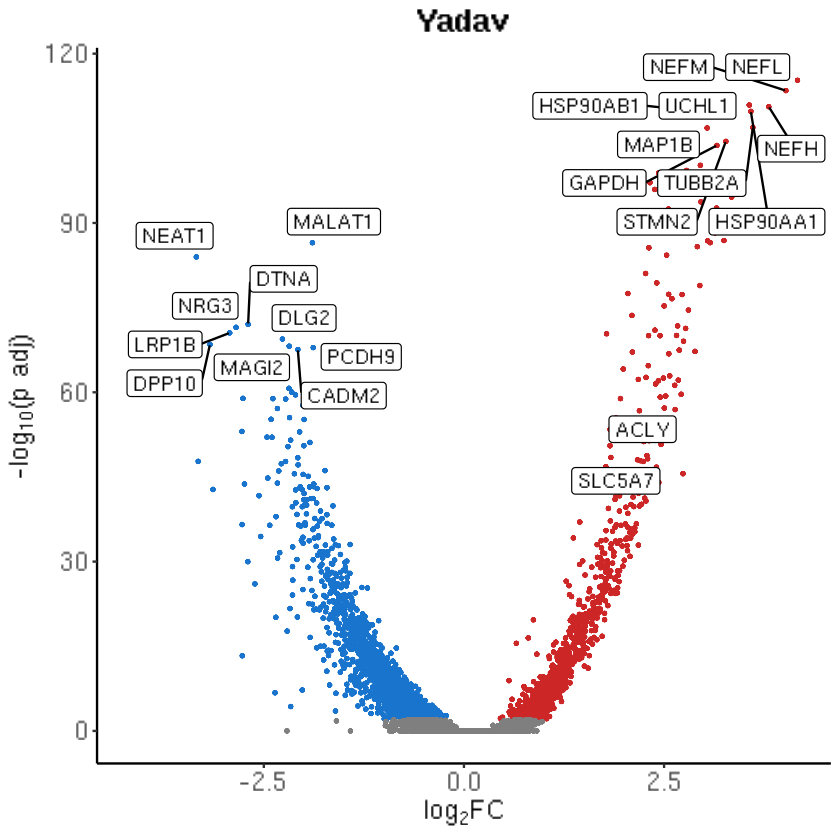

In [74]:
yadav_intronic_volcano_plot <- make_volcano_plot(yadav_intronic_markers, 10, labeled_genes = c('SLC5A7', 'ACLY')) 
yadav_intronic_volcano_plot <- rasterize(yadav_intronic_volcano_plot, layers="Point", dpi=500) + NoLegend()
yadav_intronic_volcano_plot

In [75]:
ggsave(yadav_intronic_volcano_plot, filename = paste(fig_dir, 'yadav_intronic_volcano_plot.svg', sep='/'),device='svg', width = 6.4, height = 4.848, units = "in")

In [125]:
saveRDS(yadav_prop_intronic_mns, file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic_mns.rds')

### Debris gene expression correlation heatmap

In [4]:
yadav_neurons <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_neurons.rds')
gautier_neurons <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_neurons.rds')
gautier_prop_intronic <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/gautier_prop_intronic.rds')
#yadav_prop_intronic_mns <- readRDS(file = '/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav_prop_intronic_mns.rds')

### Combine debris cluster 22, gautier_neurons, and yadav_neurons

In [109]:
c22 <- subset(gautier_prop_intronic, seurat_clusters == 22)

In [110]:
c22_avg_exp <- AverageExpression(c22, assays = c('RNA')) %>% as.data.frame()
colnames(c22_avg_exp) <- c("22 - Debris (Gautier)")
c22_avg_exp$genes <- rownames(c22_avg_exp)

The following grouping variables have 1 value and will be ignored: ident

All grouping variables have 1 value only. Computing across all cells.



In [111]:
gautier_neurons_avg_exp <- AverageExpression(gautier_neurons, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(gautier_neurons_avg_exp) <- c("Motor Neurons (Gautier)", "Other Neurons (Gautier)")
gautier_neurons_avg_exp$genes <- rownames(gautier_neurons_avg_exp)

In [116]:
yadav_neurons_avg_exp <- AverageExpression(yadav_neurons, assays = c('RNA'), group.by = "motor_neuron") %>% as.data.frame()
colnames(yadav_neurons_avg_exp) <- c("Motor Neurons (Yadav)", "Other Neurons (Yadav)")
yadav_neurons_avg_exp$genes <- rownames(yadav_neurons_avg_exp)

In [117]:
avg_exp_combo <- full_join(c22_avg_exp, gautier_neurons_avg_exp, by = "genes") %>% full_join(., yadav_neurons_avg_exp, by = "genes")
row.names(avg_exp_combo) <- avg_exp_combo$genes
avg_exp_combo <- dplyr::select(avg_exp_combo, -genes) %>% tidyr::drop_na() %>% filter_all(., any_vars(. != 0))

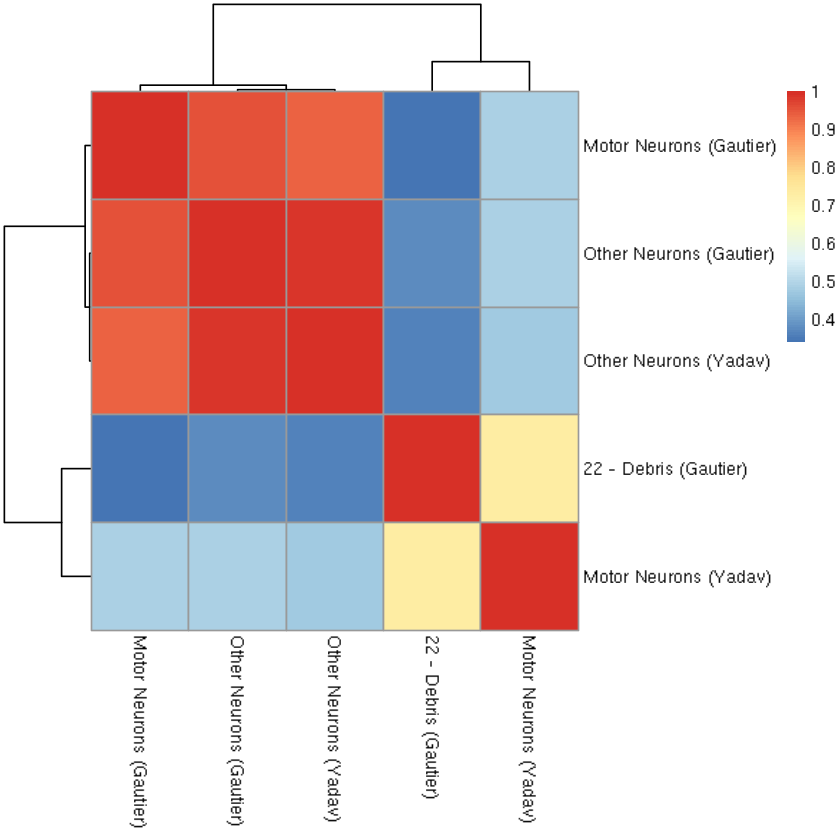

In [118]:
pheatmap(cor(as.matrix(avg_exp_combo)))

In [119]:
pheatmap(cor(as.matrix(avg_exp_combo)), filename = paste(fig_dir, 'debris_neurons_heatmap.pdf', sep='/'), cellwidth = 30, cellheight = 30, fontsize = 14)

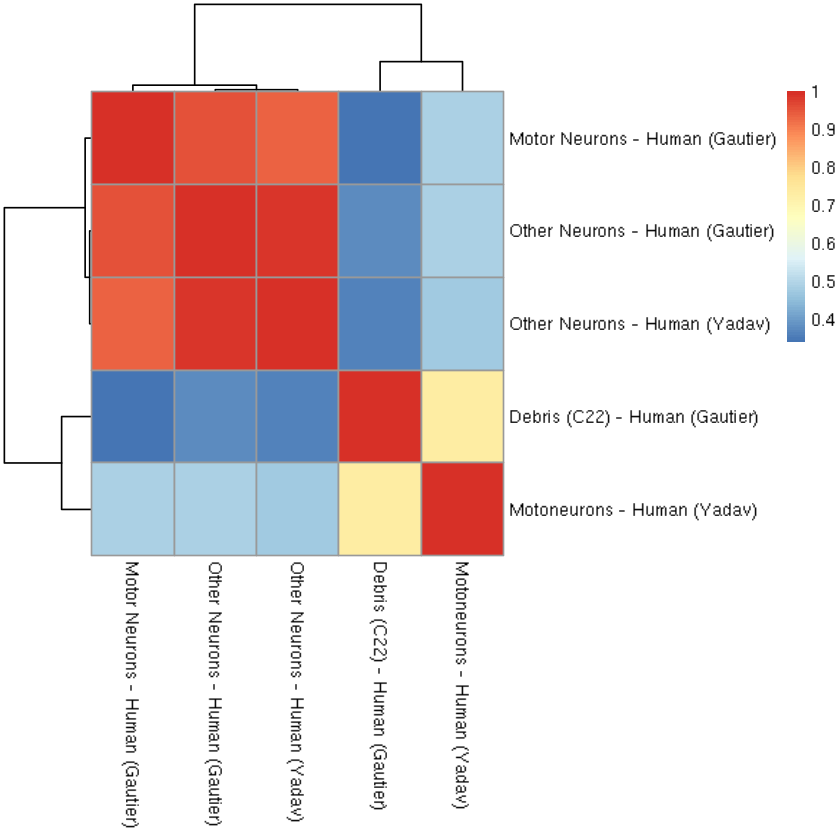

In [25]:
pheatmap(cor(as.matrix(x)))

In [ ]:
pheatmap(cor(as.matrix(avg_exp_combo)), filename = paste(fig_dir, 'debris_neurons_heatmap.pdf', sep='/'), cellwidth = 20, cellheight = 20, fontsize = 14, legend_breaks = 0:1)

In [35]:
yadav_percent_intronic_avg_exp <- AverageExpression(yadav_mns_percent_intronic, assays = c('RNA'), group.by = "intronic") %>% as.data.frame()
colnames(yadav_percent_intronic_avg_exp) <- c("High Intronic MNs - Human (Yadav)", "Low Intronic MNs - Human (Yadav)")
yadav_percent_intronic_avg_exp$genes <- rownames(yadav_percent_intronic_avg_exp)

In [37]:
avg_exp_combo2 <- inner_join(c22_avg_exp, gautier_neurons_avg_exp, by = "genes") %>% inner_join(., yadav_neurons_avg_exp, by = "genes") %>% inner_join(., yadav_percent_intronic_avg_exp, by = "genes") 
row.names(avg_exp_combo2) <- avg_exp_combo2$genes
avg_exp_combo2 <- dplyr::select(avg_exp_combo2, -genes)

In [40]:
y <- filter_all(avg_exp_combo2, any_vars(. != 0))

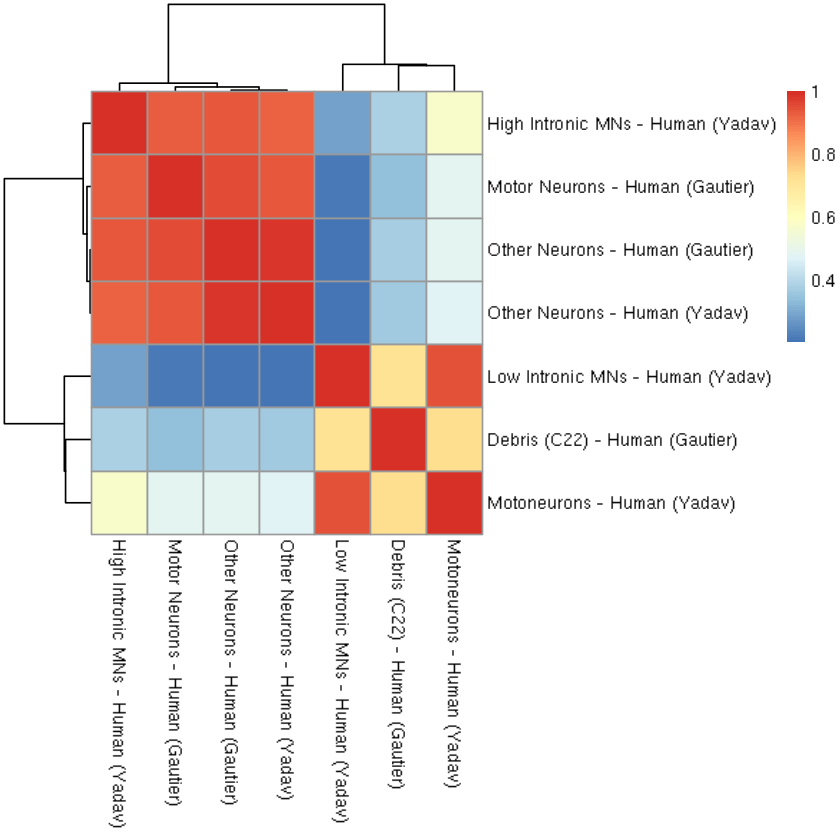

In [41]:
pheatmap(cor(as.matrix(y)))

In [43]:
yadav_neurons_avg_exp_fitlered <- filter(yadav_neurons_avg_exp, `Motoneurons - Human (Yadav)` > 0)

In [45]:
avg_exp_combo3 <- left_join(yadav_neurons_avg_exp_fitlered, gautier_neurons_avg_exp, by = "genes") %>% left_join(., c22_avg_exp, by = "genes") %>% left_join(., yadav_percent_intronic_avg_exp, by = "genes") 
row.names(avg_exp_combo3) <- avg_exp_combo3$genes
avg_exp_combo3 <- dplyr::select(avg_exp_combo3, -genes) 

In [50]:
z <- tidyr::drop_na(avg_exp_combo3)

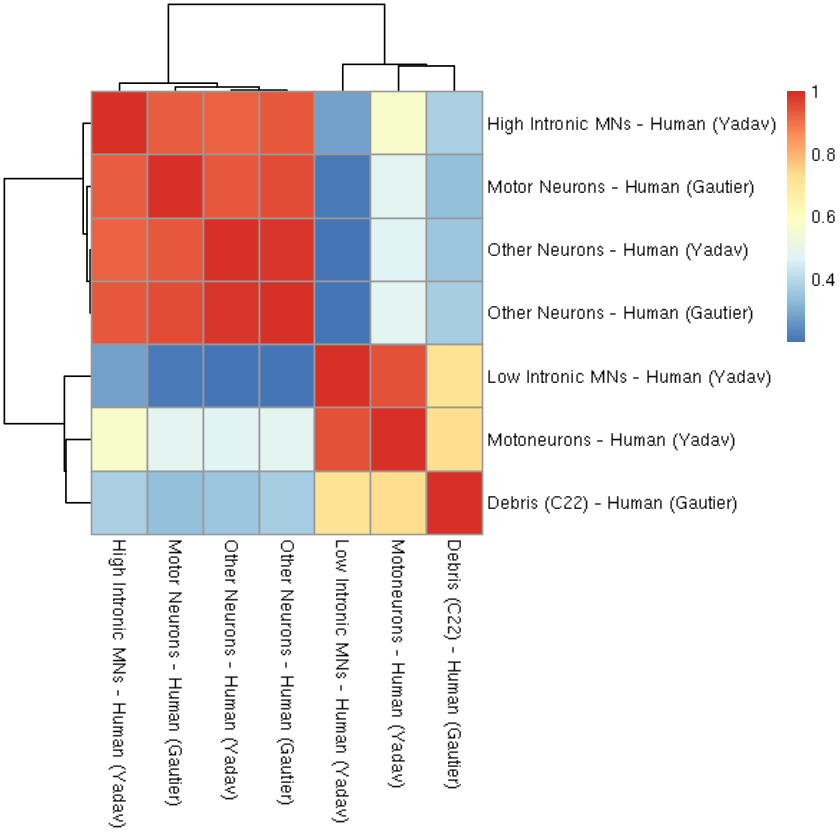

In [52]:
pheatmap(cor(as.matrix(z)))

In [53]:
yadav <- readRDS('/oak/stanford/groups/agitler/Shared/Matters_Arising/Gautier_Yadav/yadav.rds')

In [57]:
Idents(yadav) <- yadav$subtype_annotation
yadav_mn_markers <- FindMarkers(yadav, ident.1 ="Motoneurons", logfc.threshold = 1, max.cells.per.ident = 500, only.pos = TRUE)

In [59]:
yadav_mn_markers$genes <- rownames(yadav_mn_markers)

In [60]:
avg_exp_combo2 <- inner_join(c22_avg_exp, gautier_neurons_avg_exp, by = "genes") %>% inner_join(., yadav_neurons_avg_exp, by = "genes") %>% inner_join(., yadav_percent_intronic_avg_exp, by = "genes") 
row.names(avg_exp_combo2) <- avg_exp_combo2$genes

In [61]:
a <- filter(avg_exp_combo2, avg_exp_combo2$genes %in% yadav_mn_markers$genes)

In [63]:
a <- dplyr::select(a, -genes) 

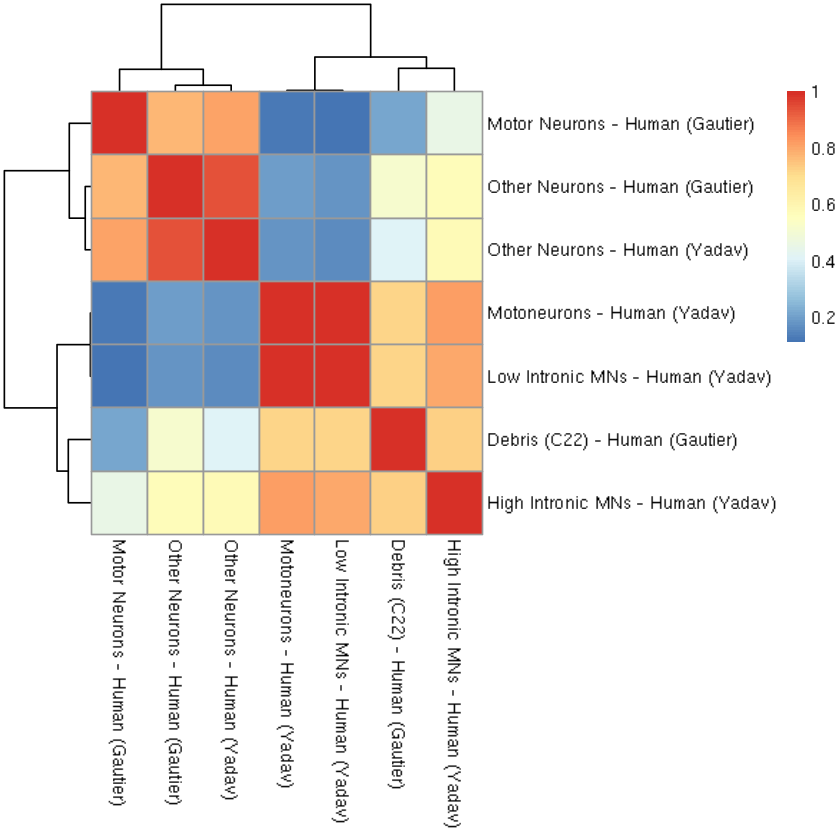

In [64]:
pheatmap(cor(as.matrix(a)))